In [1]:
from CovMat import *
import gc
from cl_and_cov import *
from signal_to_noise import *
from fisher_FoM import *
from initialize import *

In [2]:
# Input Cosmology object with a given set of parameters
cosmo = ccl.Cosmology(
    Omega_c = Omega_m-Omega_b, Omega_b=Omega_b, h=h, sigma8=sigma8, n_s=n_s,
    transfer_function=transfer_function)

In [3]:
dndz=GalaxyDistr(zi=0.001, zf=4.0, n_eff=10.024, z0=0.13, alpha=0.78)
#n_eff is chosen from the last column of Table F1,"https://arxiv.org/abs/1809.01669" LSST Science Requirements Document
#z0 and alpha are from Figure F4, Y1 of the same document

In [4]:
arcmin_per_str=(180*60/np.pi)**2
#how many square arcminutes are there in a steradian 
num_den = arcmin_per_str*10.024

In [5]:
#get data and covariance vectors
cl = {} 
cov = {}
redshifts = {}
sliced_dndz = {}

for n in range(1,7):
    for btype in ["z", "n"]:
        cov["{0}_{1}".format(btype, n)], cl["{0}_{1}".format(btype, n)], redshifts["{0}_{1}".format(btype, n)], sliced_dndz["{0}_{1}".format(btype, n)] = getDataArray(n_bins=n, bin_type=btype, cosmo=cosmo, dndz=dndz, ell=ell, numdenPerStr = num_den, fsky=0.4)

In [6]:
#binning in l
binl=10**np.linspace(np.log10(50), np.log10(8500), 20)

In [7]:
#calculating signal to noise
stn = {}
for i in ["z", "n"]:
    for j in range(1,7):
        stn["{0}_{1}".format(i,j)] = SignalToNoise(bins_in_z=j, binl=binl, cl = cl["{0}_{1}".format(i, j)], cov = cov["{0}_{1}".format(i, j)], ell=ell)

In [8]:
fisher = {}
for i in ["z", "n"]:
    for j in range(1,7):
        global dndz_sliced
        dndz_sliced = sliced_dndz["{0}_{1}".format(i, j)]
        fisher["{0}_{1}".format(i,j)] = fisher_matrix(covariance = cov["{0}_{1}".format(i, j)], dndz_sliced = sliced_dndz["{0}_{1}".format(i, j)])

In [9]:
fisher['n_5']

array([[33372.07772753, 24525.5195865 ,  -484.97955811, -1987.68612862,
        -2579.40242442,  -850.64111504,   251.87853748],
       [24525.5195865 , 19336.92249802, -1390.92049061, -1594.02000531,
        -2157.13706663,  2287.6343175 ,  -674.74400496],
       [ -484.97955811, -1390.92049061,  1467.07140919,   209.73501218,
          278.75252542, -3319.2158215 ,   977.77008296],
       [-1987.68612862, -1594.02000531,   209.73501218,   144.84030942,
          190.44346474,  -356.69710735,   104.91440585],
       [-2579.40242442, -2157.13706663,   278.75252542,   190.44346474,
          266.78877336,  -534.76115877,   157.47383496],
       [ -850.64111504,  2287.6343175 , -3319.2158215 ,  -356.69710735,
         -534.76115877,  8710.54024437, -2568.79851512],
       [  251.87853748,  -674.74400496,   977.77008296,   104.91440585,
          157.47383496, -2568.79851512,   757.57334854]])

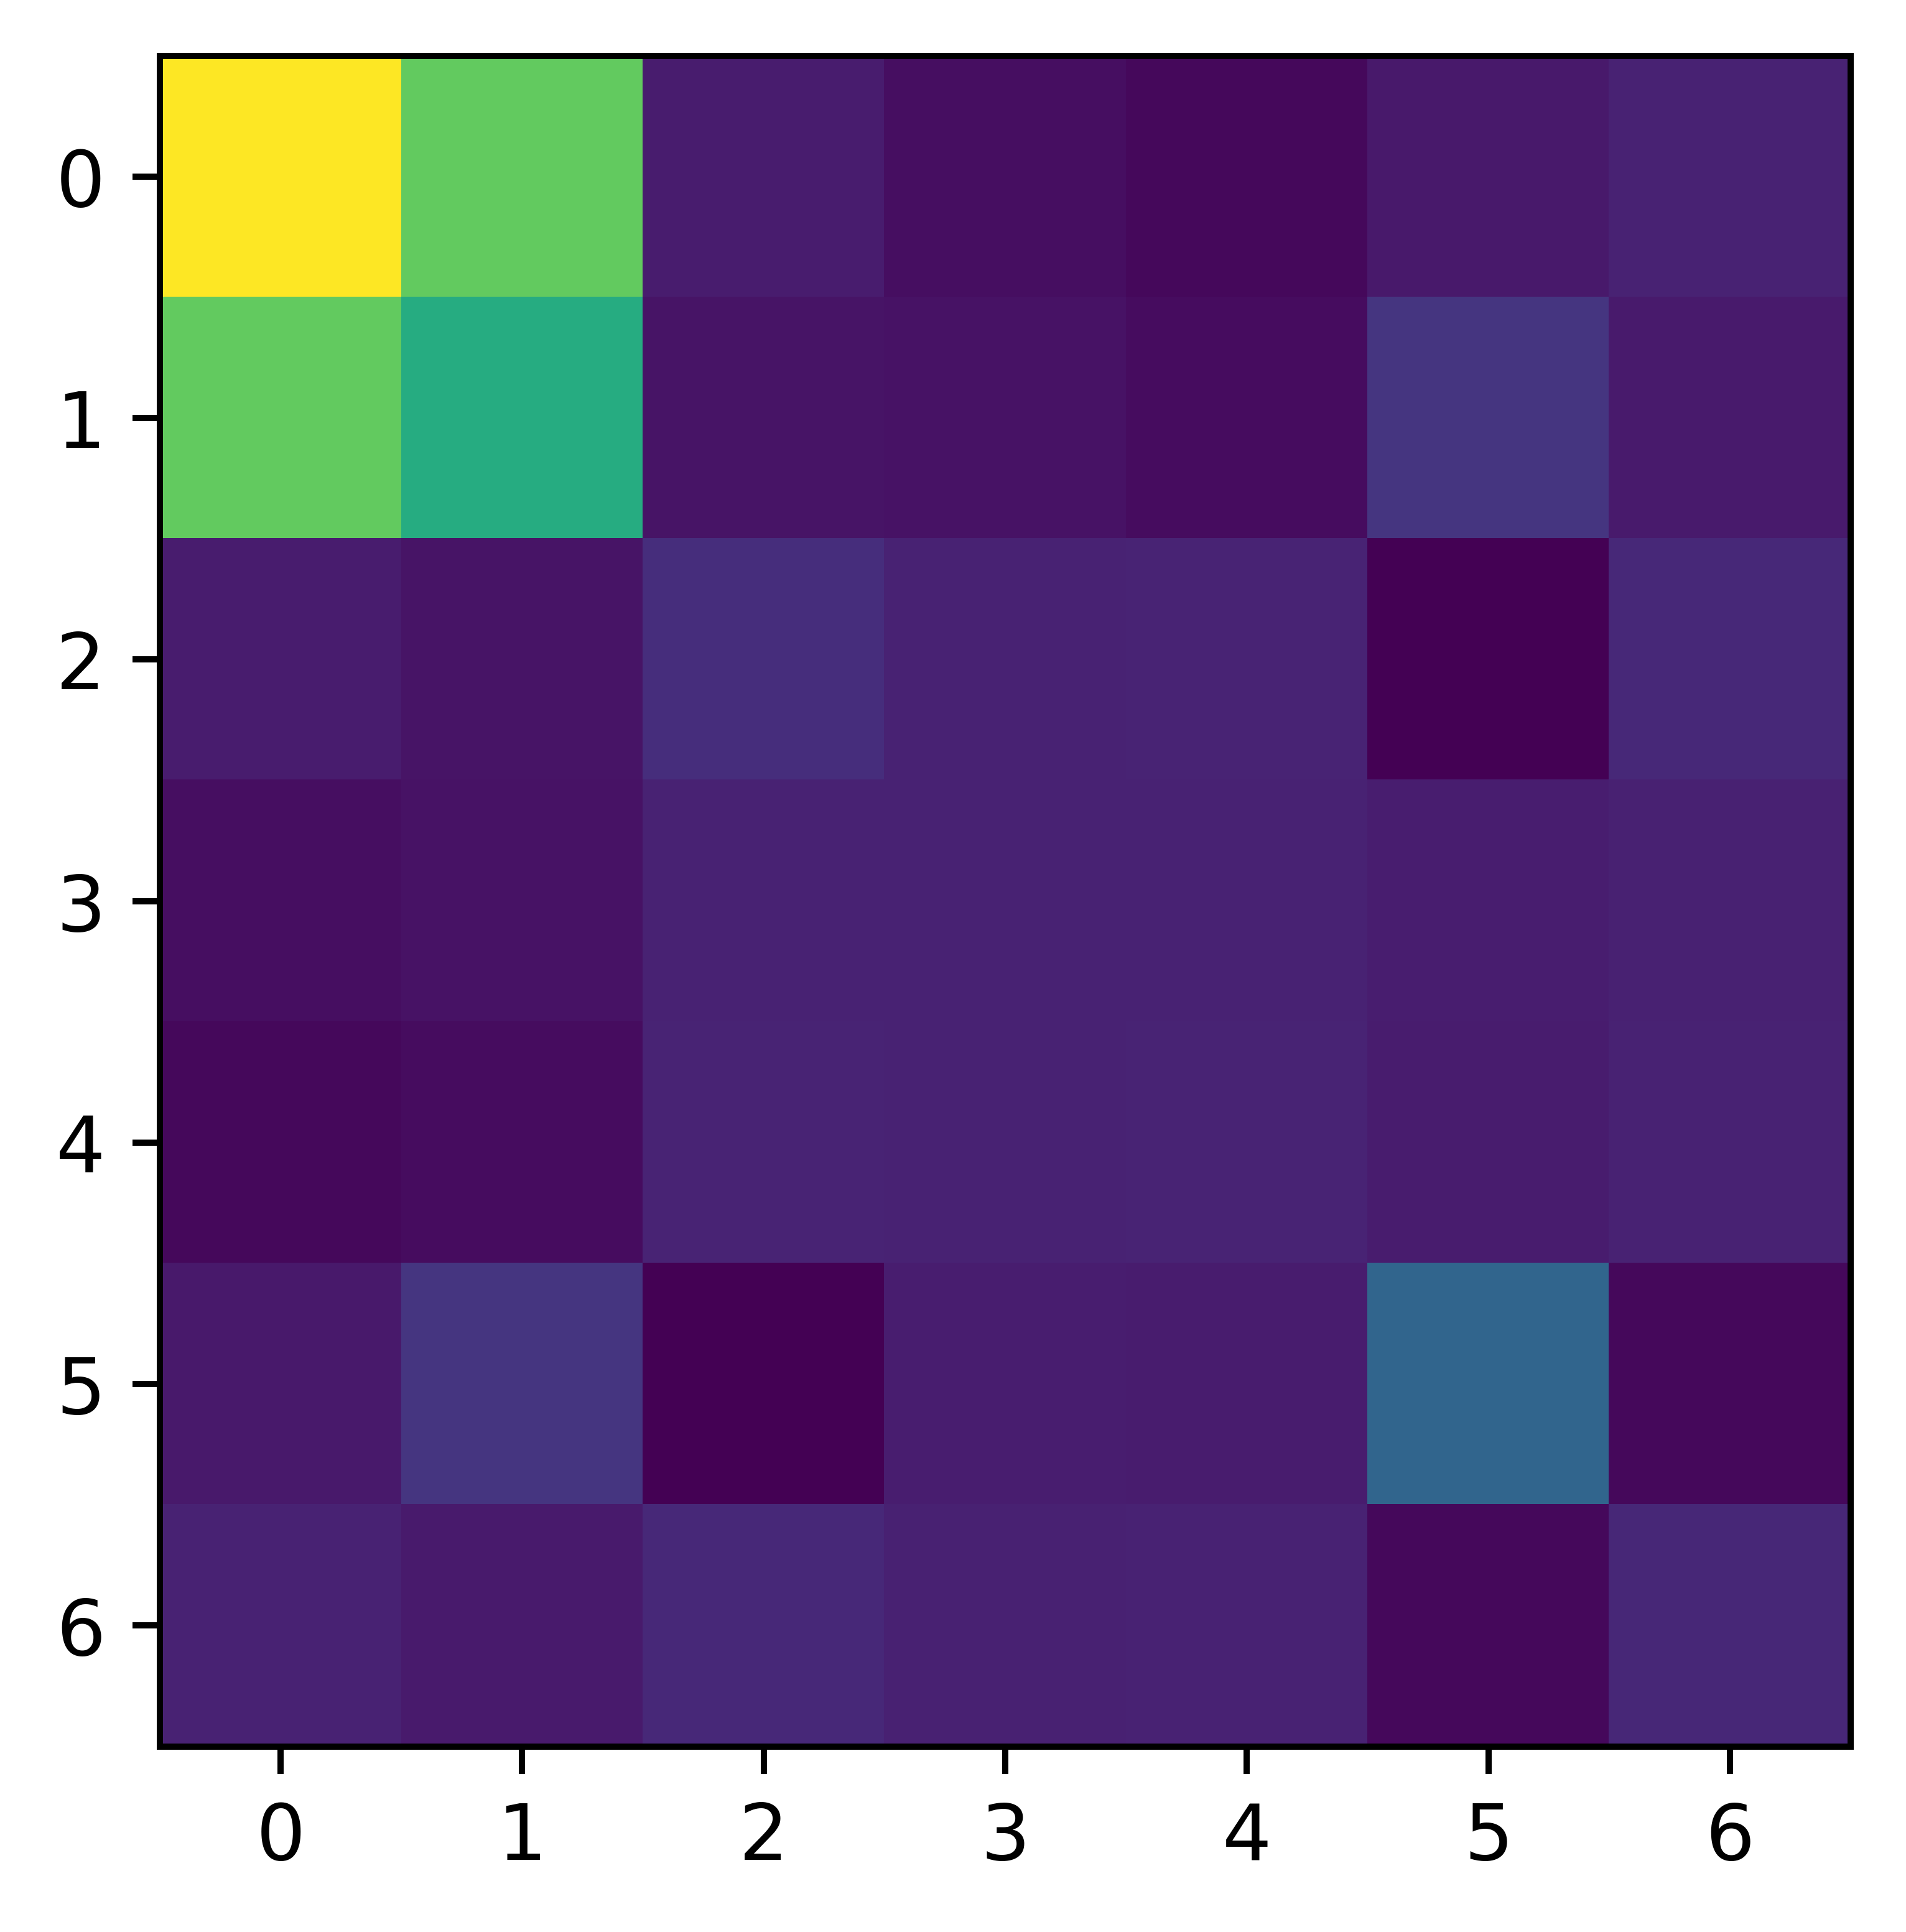

In [10]:
plt.imshow(fisher['n_5'])

In [11]:
fisher['n_5'][3,3]

144.84030942287293

In [12]:
for i in range(1,7):
    print(fisher['n_{}'.format(i)][3,3])
    print(fisher['z_{}'.format(i)][3,3])    

77.93176939306585
77.93840662240899
125.5315524858521
797.7132272617148
136.0220260102864
758.2511471790598
140.38107928761286
629.4137946608234
144.84030942287293
534.4064487468157
143.84686204166263
470.74373534316624


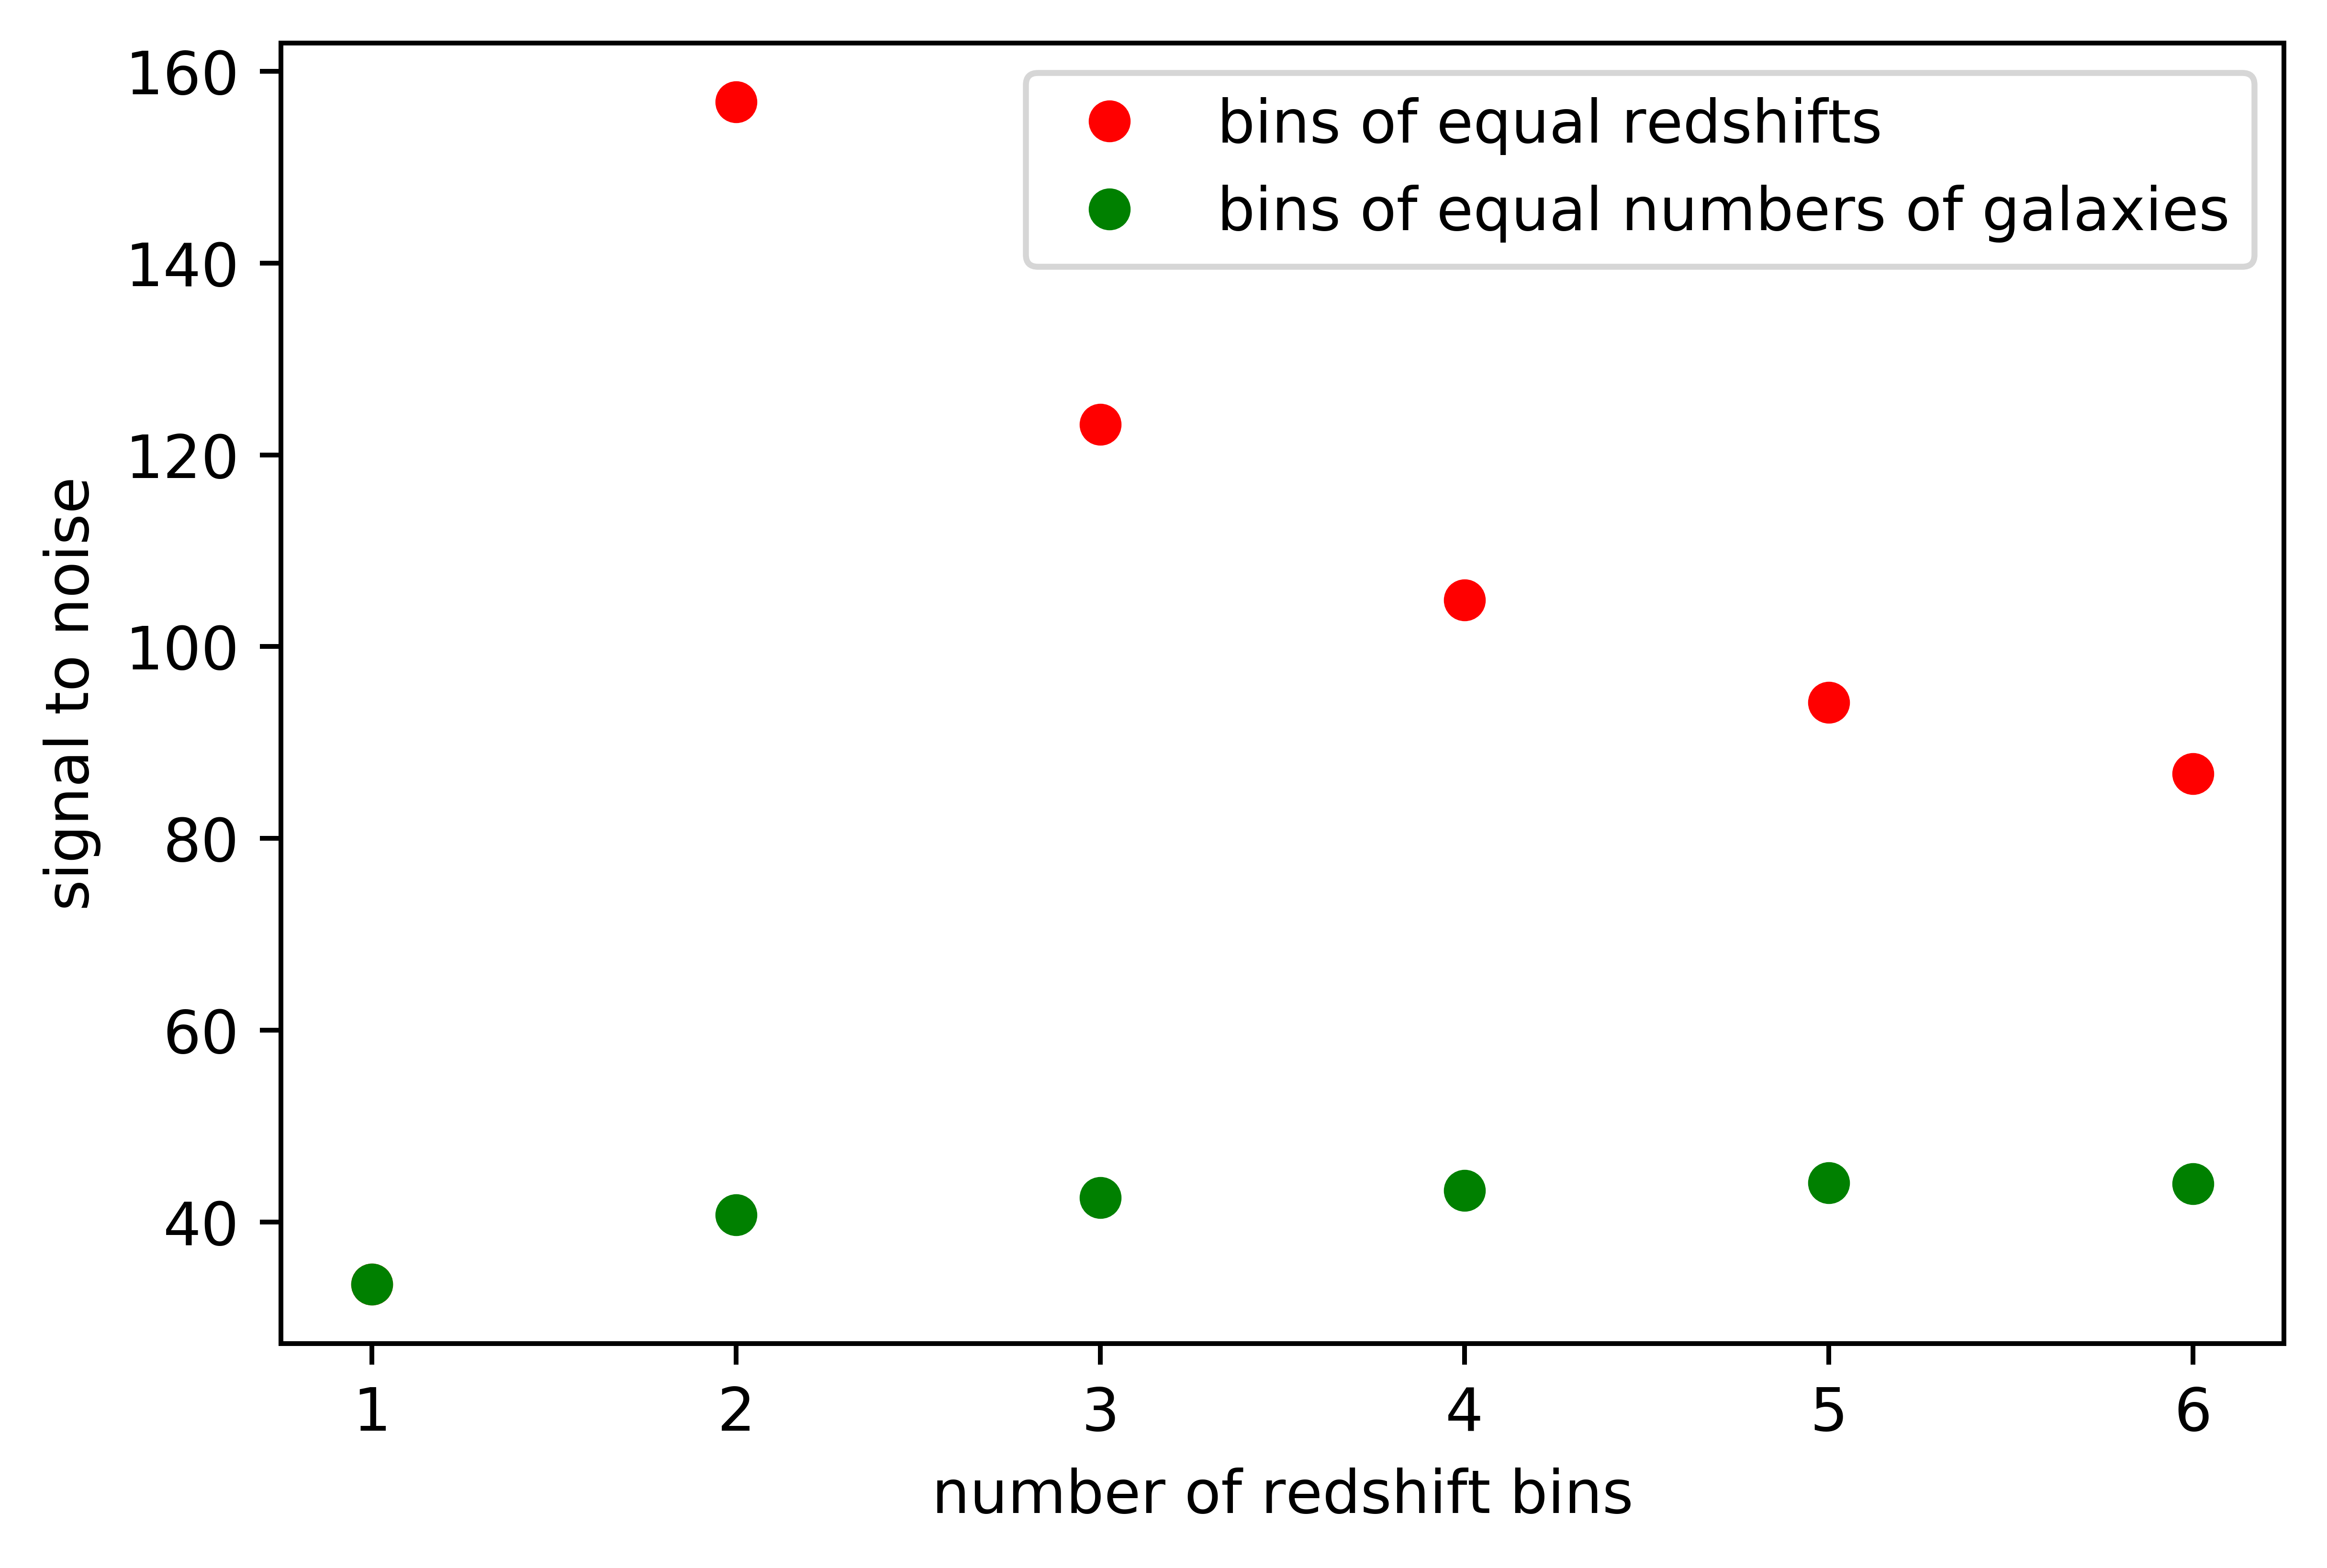

In [14]:
params = {'legend.fontsize': 10,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.figure()
plt.plot([1, 2, 3, 4, 5, 6], [stn["z_1"], stn["z_2"], stn["z_3"], stn["z_4"], stn["z_5"], stn["z_6"]],
         color='r', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal redshifts")
plt.plot([1, 2, 3, 4, 5, 6], [stn["n_1"], stn["n_2"], stn["n_3"], stn["n_4"], stn["n_5"], stn["n_6"]],
         color='g', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal numbers of galaxies")
plt.xlabel("number of redshift bins")
plt.ylabel("signal to noise")
plt.legend(loc="upper right")
plt.show() 

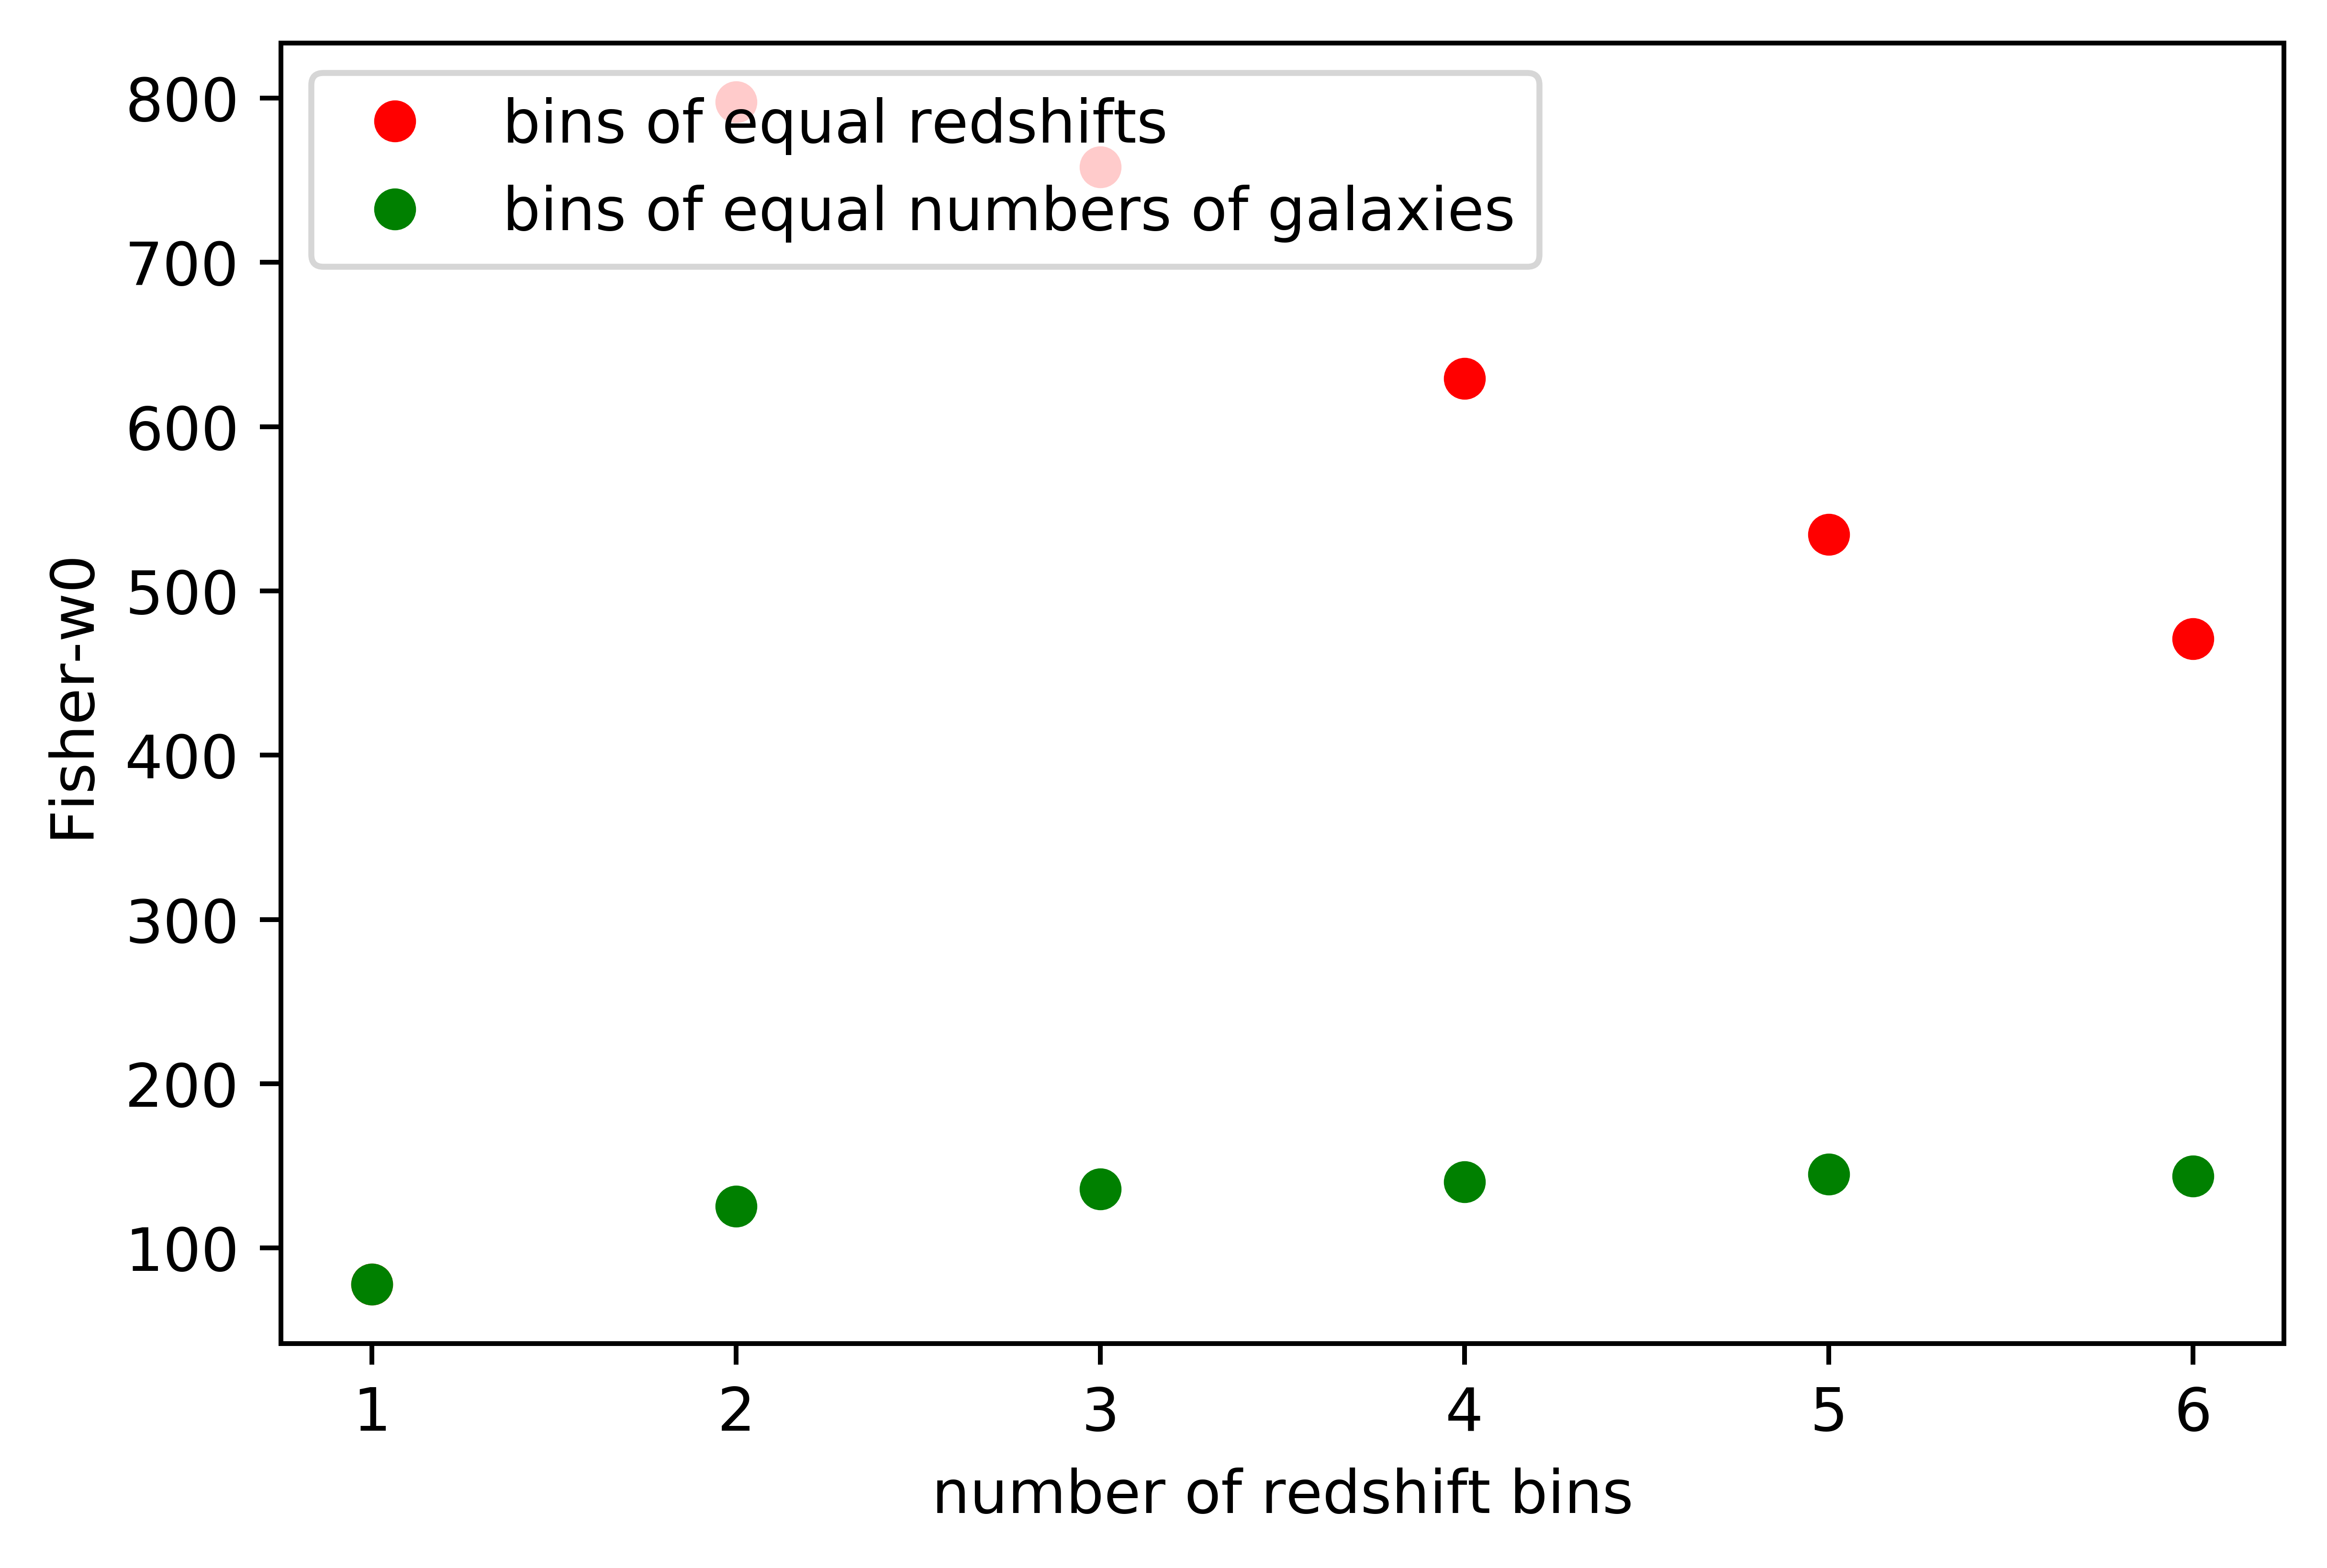

In [15]:
params = {'legend.fontsize': 10,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.figure()
plt.plot([1, 2, 3, 4, 5, 6], [fisher["z_1"][3,3], fisher["z_2"][3,3], fisher["z_3"][3,3], fisher["z_4"][3,3], fisher["z_5"][3,3], fisher["z_6"][3,3]],
         color='r', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal redshifts")
plt.plot([1, 2, 3, 4, 5, 6], [fisher["n_1"][3,3], fisher["n_2"][3,3], fisher["n_3"][3,3], fisher["n_4"][3,3], fisher["n_5"][3,3], fisher["n_6"][3,3]],
         color='g', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal numbers of galaxies")
plt.xlabel("number of redshift bins")
plt.ylabel("Fisher-w0")
plt.legend(loc="upper left")
plt.show() 